Importacón de librerías necesarías para el proyecto

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import random
import matplotlib.pyplot as plt

Dataset

In [ ]:
df = pd.read_csv("/content/btcusd_1-min_data.csv")

In [ ]:
# Preprocesamiento de fecha y cierre
df['Date'] = pd.to_datetime(df['Timestamp'], unit='s')
df = df.set_index('Date')[['Close']].copy()
df.dropna(inplace=True)

In [ ]:
# Escalado
scaler = MinMaxScaler()
scaled_close = scaler.fit_transform(df[['Close']].values).flatten()

In [ ]:
# Función para crear secuencias
def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len])
    return np.array(X), np.array(y)

In [ ]:
# Modelo LSTM
class BitcoinLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout):
        super(BitcoinLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

In [ ]:
# Entrenamiento
def train_model(model, X_train, y_train, X_val, y_val, num_epochs, lr):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        output = model(X_train)
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        preds = model(X_val)
        val_loss = criterion(preds, y_val).item()
    return val_loss

In [ ]:
import gc
import random
import torch
from sklearn.model_selection import train_test_split

1. Objetivo:
- Optimiza hiperparámetros para la LSTM usando un algoritmo genético. Busca la mejor combinación de:

        seq_len (longitud de secuencia)

        hidden_size (neuronas en capa oculta)

        num_layers (capas LSTM)

        dropout (regularización)

        lr (tasa de aprendizaje)

2. Flujo Principal:

        Población Inicial: Genera pop_size individuos con valores aleatorios dentro de rangos definidos.

        Evaluación: Para cada individuo:

        Crea secuencias con create_sequences()

        Entrena el modelo LSTM brevemente (2 épocas)

        Evalúa el rendimiento usando pérdida en validación (MSE)

        Selección: Conserva los mejores individuos (menor pérdida).

        Reproducción: Genera nueva población combinando (cruce) y modificando (mutación) los mejores.

3. Detalles Clave:

          Restricción RAM: Usa max_samples para limitar datos.

          Seguridad: Si hay menos de 2 individuos válidos, aborta.

          Memoria: Libera memoria explícitamente (importante para GPU).


4. Parámetros por Defecto:

          Población pequeña (pop_size=4)

          Pocas generaciones (generations=2)

          Muestra máxima de 100k puntos (max_samples)

5. Salida:
          Devuelve el mejor individuo (hiperparámetros) encontrado.

In [ ]:
def genetic_algorithm(y, pop_size=4, generations=2, max_samples=100_000):
    population = []

    # Crear población inicial
    for _ in range(pop_size):
        individual = {
            'seq_len': random.randint(10, 50),
            'hidden_size': random.choice([16, 32, 64, 128]),
            'num_layers': random.choice([1, 2, 3]),
            'dropout': random.uniform(0.0, 0.5),
            'lr': random.uniform(0.0005, 0.01)
        }
        if individual['num_layers'] == 1:
            individual['dropout'] = 0.0
        population.append(individual)

    for gen in range(generations):
        fitness_scores = []

        for ind in population:
            seq_len = ind['seq_len']

            # Limitar tamaño del dataset para no saturar la RAM
            y_sample = y[:max_samples]

            # Crear secuencias
            X, y_seq = create_sequences(y_sample, seq_len)
            if len(X) < 500:
                continue

            X_train, X_val, y_train, y_val = train_test_split(X, y_seq, test_size=0.2, shuffle=False)

            # Convertir a tensores
            X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)
            y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
            X_val = torch.tensor(X_val, dtype=torch.float32).unsqueeze(-1)
            y_val = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

            # Crear y entrenar modelo
            model = BitcoinLSTM(1, ind['hidden_size'], ind['num_layers'], ind['dropout'])
            loss = train_model(model, X_train, y_train, X_val, y_val, num_epochs=2, lr=ind['lr'])
            fitness_scores.append((loss, ind))

            # Liberar memoria
            del model, X_train, y_train, X_val, y_val
            torch.cuda.empty_cache()
            gc.collect()

        if len(fitness_scores) < 2:
            print("⚠️ Muy pocos individuos válidos, intenta aumentar `pop_size` o mejorar `create_sequences`.")
            break

        # Seleccionar los mejores
        fitness_scores.sort(key=lambda x: x[0])
        best = fitness_scores[:max(2, pop_size // 2)]

        new_population = [ind for _, ind in best]

        # Cruce y mutación
        while len(new_population) < pop_size:
            if len(new_population) >= 2:
                p1, p2 = random.sample(new_population, 2)
            else:
                p1 = p2 = new_population[0]

            child = {
                'seq_len': random.choice([p1['seq_len'], p2['seq_len']]),
                'hidden_size': random.choice([p1['hidden_size'], p2['hidden_size']]),
                'num_layers': random.choice([p1['num_layers'], p2['num_layers']]),
                'dropout': max(0.0, min(0.5, (p1['dropout'] + p2['dropout']) / 2 + random.uniform(-0.05, 0.05))),
                'lr': max(0.0001, min(0.01, (p1['lr'] + p2['lr']) / 2 + random.uniform(-0.001, 0.001)))
            }

            if child['num_layers'] == 1:
                child['dropout'] = 0.0

            new_population.append(child)

        population = new_population
        print(f"🧬 Gen {gen+1}/{generations}, Mejor pérdida: {best[0][0]:.6f}")

    return fitness_scores[0][1]

In [ ]:
best_hparams = genetic_algorithm(y=scaled_close, pop_size=4, generations=2)
print("📌 Mejores hiperparámetros encontrados:", best_hparams)

🧬 Gen 1/2, Mejor pérdida: 0.000099
🧬 Gen 2/2, Mejor pérdida: 0.000041
📌 Mejores hiperparámetros encontrados: {'seq_len': 20, 'hidden_size': 32, 'num_layers': 3, 'dropout': 0.2653036041621139, 'lr': 0.0015289256279720606}


In [ ]:
# best_hparams = genetic_algorithm(y=scaled_close, pop_size=4, generations=2)
# print("🧬 Mejores hiperparámetros encontrados:", best_hparams)

In [ ]:
# Entrenar modelo final con los mejores parametros encontrados por el algoritmo genetico
# seq_len = best_hparams['seq_len']
seq_len = 20
X, y_seq = create_sequences(scaled_close, seq_len)
X_train, X_val, y_train, y_val = train_test_split(X, y_seq, test_size=0.2, shuffle=False)

X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_val = torch.tensor(X_val, dtype=torch.float32).unsqueeze(-1)
y_val = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

model = BitcoinLSTM(
    input_size=1,
    # hidden_size=best_hparams['hidden_size'],
    hidden_size=32,
    # num_layers=best_hparams['num_layers'],
    num_layers=3,
    # dropout=best_hparams['dropout']
    dropout=0.2653036041621139,
)

train_model(model, X_train, y_train, X_val, y_val, num_epochs=20,
            # lr=best_hparams['lr']
            lr=0.0015289256279720606)

0.02983376570045948

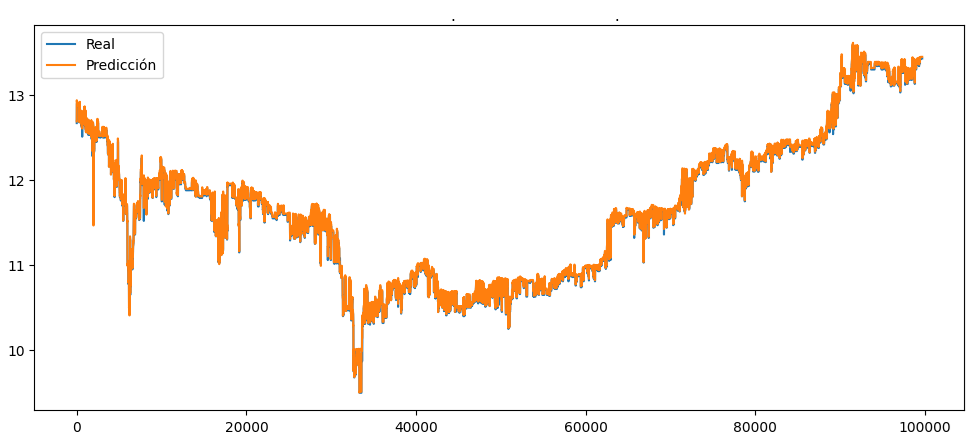